In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from nltk import FreqDist

from tqdm.auto import tqdm
import re
import contractions
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

from bs4 import MarkupResemblesLocatorWarning
import warnings

## Подготовка датасета

### Чтение датасета

In [4]:
questions = pd.read_csv("dataset/Questions.csv", encoding="ISO-8859-1")
questions.head(5)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [5]:
tags = pd.read_csv("dataset/Tags.csv", encoding="ISO-8859-1")
tags.head(5)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [6]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [7]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


### Группировка и объединение тегов

In [8]:
tags["Tag"] = tags["Tag"].astype(str)
grouped_tags = tags.groupby("Id")["Tag"].apply(lambda tags: " ".join(tags))
grouped_tags.head(10)

Id
80                               flex actionscript-3 air
90          svn tortoisesvn branch branching-and-merging
120                                  sql asp.net sitemap
180       algorithm language-agnostic colors color-space
260              c# .net scripting compiler-construction
330                           c++ oop class nested-class
470                                    .net web-services
580    sql-server sql-server-2005 deployment release-...
650                          c# visual-studio versioning
810          windows visual-studio registry installation
Name: Tag, dtype: object

In [9]:
grouped_tags.shape

(1264216,)

In [10]:
df_grouped_tags = grouped_tags.reset_index(name='Tags')
df_grouped_tags.columns = ['Id', 'Tags']
df_grouped_tags.head(5)

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


### Удаление ненужных колонок

In [11]:
questions.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)
questions.head(5)

,Id,Score,Title,Body
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


### Объединение вопросов и тегов

In [12]:
data = questions.merge(df_grouped_tags, on='Id')
data.head(10)

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction
5,330,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,c++ oop class nested-class
6,470,13,Homegrown consumption of web services,<p>I've been writing a few web services for a ...,.net web-services
7,580,21,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...,sql-server sql-server-2005 deployment release-...
8,650,79,Automatically update version number,<p>I would like the version property of my app...,c# visual-studio versioning
9,810,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,windows visual-studio registry installation


### Анализ и работа с показателем рейтинга (Score)

#### Метрики

In [13]:
print(f"Minimum Score: {data['Score'].min()}")
print(f"Maximum Score: {data['Score'].max()}")

print(f"Total count {data["Score"].count()}")
print(f"Count (Score > 0) {data[data["Score"] > 0]["Score"].count()}")
print(f"Count (Score > 5) {data[data["Score"] > 5]["Score"].count()}")
print(f"Count (Score > 10) {data[data["Score"] > 20]["Score"].count()}")
print(f"Count (Score > 20) {data[data["Score"] > 10]["Score"].count()}")

print(f"Describe\n{data["Score"].describe()}")

Minimum Score: -73
Maximum Score: 5190
Total count 1264216
Count (Score > 0) 594057
Count (Score > 5) 72950
Count (Score > 10) 14114
Count (Score > 20) 32604
Describe
count    1.264216e+06
mean     1.781537e+00
std      1.366389e+01
min     -7.300000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      5.190000e+03
Name: Score, dtype: float64


#### График распределения рейтинга

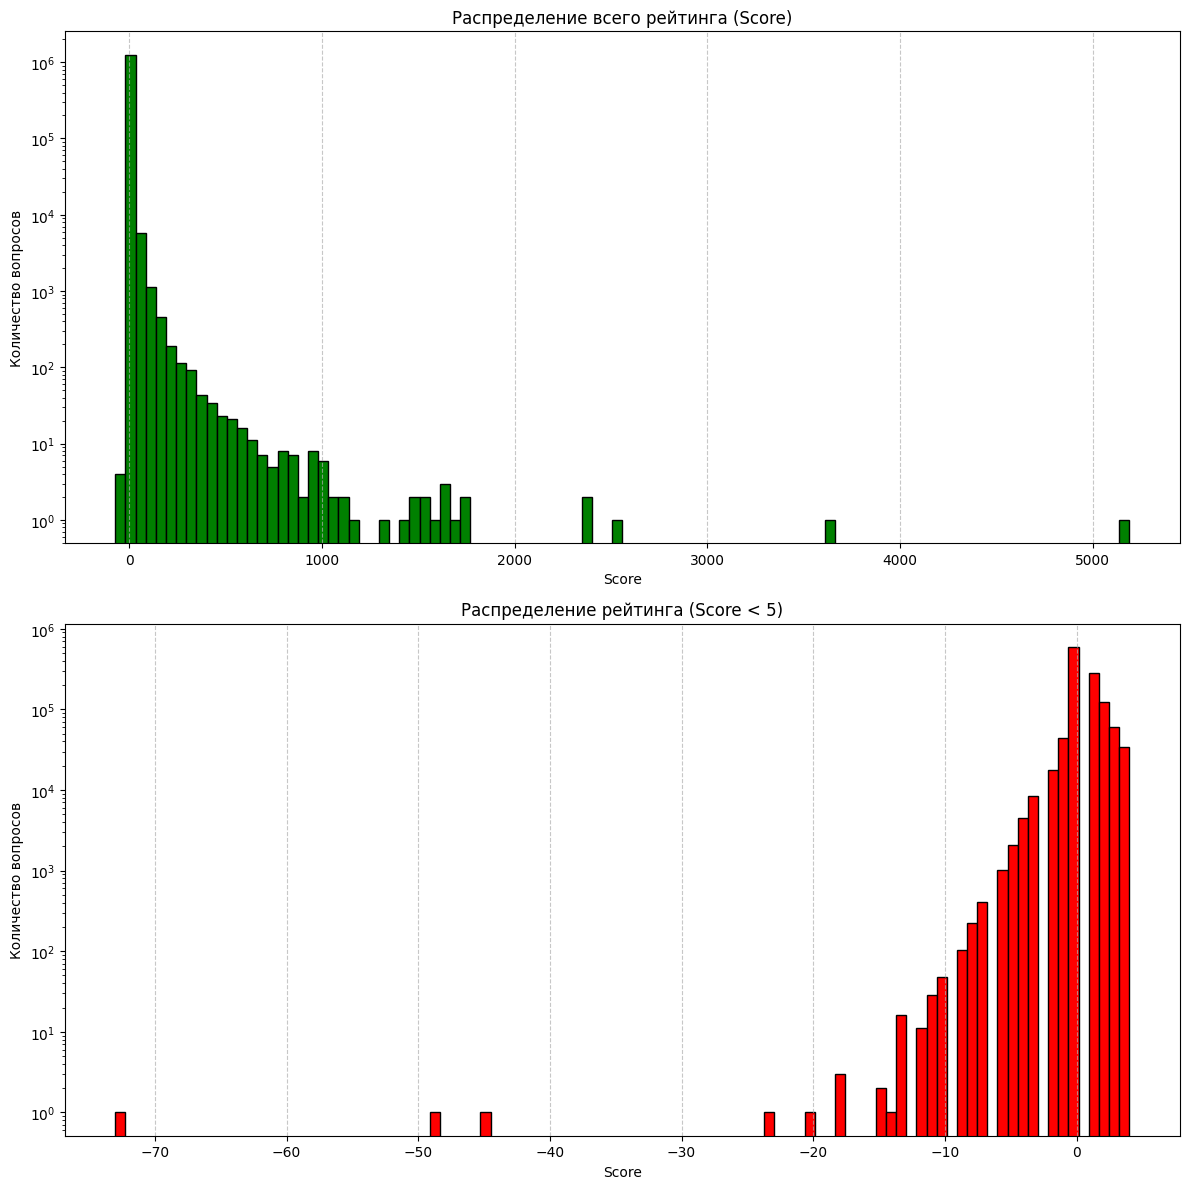

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# График 1: Все значения Score
ax1.hist(data["Score"], bins=100, color='green', edgecolor='black')
ax1.set_title('Распределение всего рейтинга (Score)')
ax1.set_xlabel('Score')
ax1.set_ylabel('Количество вопросов')
ax1.set_yscale('log')
ax1.grid(axis='x', linestyle='--', alpha=0.7)

# График 2: Только Score < 5
ax2.hist(data[data['Score'] < 5]["Score"], bins=100, color='red', edgecolor='black')
ax2.set_title('Распределение рейтинга (Score < 5)')
ax2.set_xlabel('Score')
ax2.set_ylabel('Количество вопросов')
ax2.set_yscale('log')
ax2.grid(axis='x', linestyle='--', alpha=0.7)

# Автоматическая настройка отступов между графиками
plt.tight_layout()
plt.show()

#### Удаление записей с низким показателем рейтига, удаление ненужных

In [15]:
data = data[data['Score'] > 5]
data.drop(columns=['Id', 'Score'], inplace=True)

print(data.shape)
data.info()

(72950, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 72950 entries, 0 to 1264205
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   72950 non-null  object
 1   Body    72950 non-null  object
 2   Tags    72950 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB


In [16]:
data.head(10)

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction
5,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,c++ oop class nested-class
6,Homegrown consumption of web services,<p>I've been writing a few web services for a ...,.net web-services
7,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...,sql-server sql-server-2005 deployment release-...
8,Automatically update version number,<p>I would like the version property of my app...,c# visual-studio versioning
9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,windows visual-studio registry installation


### Подготовка тегов 

#### Пребразование строки тегов в список тегов

In [17]:
data['Tags'] = data['Tags'].apply(lambda x: x.split())
data.head(10)

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]"
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]"
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s..."
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]"
5,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"[c++, oop, class, nested-class]"
6,Homegrown consumption of web services,<p>I've been writing a few web services for a ...,"[.net, web-services]"
7,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...,"[sql-server, sql-server-2005, deployment, rele..."
8,Automatically update version number,<p>I would like the version property of my app...,"[c#, visual-studio, versioning]"
9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,"[windows, visual-studio, registry, installation]"


#### Удаление редких тегов

In [18]:
flat_series = data['Tags'].explode()

unique_tags_count = flat_series.nunique()
tag_counts = flat_series.value_counts()
total_tags = flat_series.count()

print(f"Total tags: {total_tags}")
print(f"Unique tags: {unique_tags_count}")
print(tag_counts.head(10))

Total tags: 224129
Unique tags: 14883
Tags
c#            6907
java          6862
javascript    5560
android       5052
python        4442
c++           4369
php           3024
jquery        2770
.net          2705
ios           2685
Name: count, dtype: int64


In [134]:
COMMON_TAGS_COUNT = 100

In [20]:
keywords = FreqDist(flat_series)
tags_features = [word[0] for word in keywords.most_common(COMMON_TAGS_COUNT)]

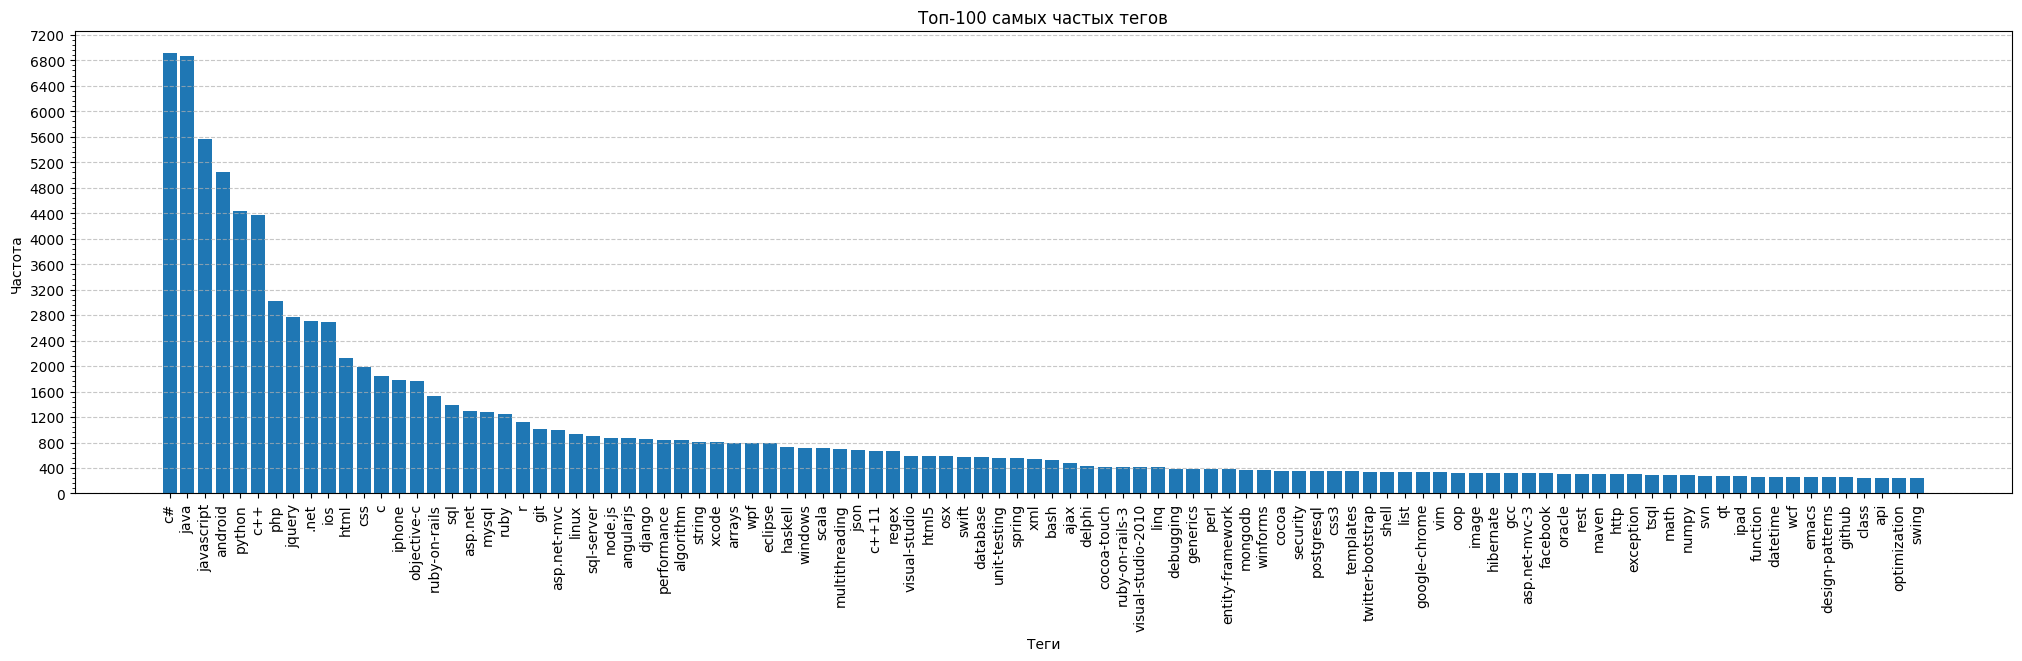

In [21]:
fig, ax = plt.subplots(figsize=(25, 6))

labels, frequencies = zip(*keywords.most_common(COMMON_TAGS_COUNT))
ax.bar(range(len(labels)), frequencies)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)

ax.yaxis.set_major_locator(ticker.MaxNLocator(20)) 
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Топ-100 самых частых тегов')
plt.xlabel('Теги')
plt.ylabel('Частота')
plt.show()

In [22]:
tags_features_set = set(tags_features)

mask = data["Tags"].apply(lambda tags: any(tag in tags_features_set for tag in tags))
filtered_data = data[mask].copy()

filtered_data["Tags"] = filtered_data["Tags"].apply(
    lambda tags: [tag for tag in tags if tag in tags_features_set]
)

data = filtered_data[filtered_data["Tags"].apply(len) > 0]

data

,Title,Body,Tags
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn]
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm]
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"
5,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"[c++, oop, class]"
...,...,...,...
1262834,STL list very bad performance,"<p>It's supposed that ""push_back"" and ""pop_fro...","[c++, list]"
1262915,How to use a dict to subset a DataFrame?,"<p>Say, I have given a DataFrame with most of ...",[python]
1263065,Is there a way to use itertools in python to c...,<p>Let's say I have the following code:</p>\n\...,[python]
1263454,Why does my result data returned as void* gets...,<p>I am working in a project with a huge legac...,[c++]


### Подготовка заголовка и описания

#### Изначальный вид описания


In [23]:
for idx, text in data["Body"].head(5).items():
    print(f"=== Запись {idx} ===")
    print(text[:200] + "...")  # Первые 200 символов для краткости
    print("\n")

=== Запись 1 ===
<p>Are there any really good tutorials explaining <a href="http://svnbook.red-bean.com/en/1.8/svn.branchmerge.html" rel="nofollow">branching and merging</a> with Apache Subversion? </p>

<p>All the be...


=== Запись 2 ===
<p>Has anyone got experience creating <strong>SQL-based ASP.NET</strong> site-map providers?</p>

<p>I've got the default XML file <code>web.sitemap</code> working properly with my Menu and <strong>Si...


=== Запись 3 ===
<p>This is something I've pseudo-solved many times and never quite found a solution. That's stuck with me. The problem is to come up with a way to generate <code>N</code> colors, that are as distingui...


=== Запись 4 ===
<p>I have a little game written in C#. It uses a database as back-end. It's 
a <a href="http://en.wikipedia.org/wiki/Collectible_card_game">trading card game</a>, and I wanted to implement the functio...


=== Запись 5 ===
<p>I am working on a collection of classes used for video playback and recording. I have on

#### Инициализация зависимостей и настройка NLTK

In [24]:
tqdm.pandas()

nltk.download('punkt')       # Токенизатор
nltk.download('stopwords')   # Стоп-слова
nltk.download('wordnet')     # Лемматизатор
nltk.download('punkt_tab')   # Таблицы для токенизации (требуется для некоторых версий NLTK)

# Указываем путь для сохранения данных (если нужно)
nltk.data.path.append("/home/ql/nltk_data") 

# Проверяем загрузку
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("""
            FAILED (btw)
          """)

[nltk_data] Downloading package punkt to /home/ql/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ql/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ql/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/ql/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#### Конвейер обработки

In [25]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punct = set('!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~')

def preprocess_text(text: str) -> str:
    """
    Полная предобработка текста:
    1. Удаление HTML-тегов
    2. Расширение сокращений
    3. Удаление спецсимволов и цифр
    4. Лемматизация
    5. Удаление стоп-слов
    """
    if pd.isna(text):
        return ""
    if not isinstance(text, str) or text.strip() == '':
        return ''
    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    # HTML -> текст
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # Расширение сокращений и очистка
    text = contractions.fix(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)  # Удаляем всё кроме букв и пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Токенизация и лемматизация
    tokens = word_tokenize(text)
    processed = [
        lemmatizer.lemmatize(token, pos='v')  # Сначала глаголы
        for token in tokens
        if token not in stop_words and token not in punct
    ]
    return ' '.join(processed)

#### Обработка

In [26]:
# Применяем обработку к Title и Body
for column in ('Title', 'Body'):
    tqdm.pandas(desc=f"Processing {column}")
    data[column] = data[column].progress_apply(preprocess_text)

data = data.dropna(subset=['Title', 'Body', 'Tags'], how='any')
print(data[data["Body"].isnull()].count())
print(data[data["Title"].isnull()].count())
print(data[data["Tags"].isnull()].count())


# Сохраняем результат
data.to_csv('processed_dataset/processed_questions.csv', index=False)

data.info()

Processing Title:   0%|          | 0/63167 [00:00<?, ?it/s]

Processing Body:   0%|          | 0/63167 [00:00<?, ?it/s]

Title    0
Body     0
Tags     0
dtype: int64
Title    0
Body     0
Tags     0
dtype: int64
Title    0
Body     0
Tags     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 63167 entries, 1 to 1264205
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   63167 non-null  object
 1   Body    63167 non-null  object
 2   Tags    63167 non-null  object
dtypes: object(3)
memory usage: 1.9+ MB


#### Итог

In [27]:
for idx, text in data["Body"].head(5).items():
    print(f"=== Запись {idx} ===")
    print(text[:200] + "...")
    print("\n")

=== Запись 1 ===
really good tutorials explain branch merge apache subversion better specific tortoisesvn client...


=== Запись 2 ===
anyone get experience create sql base asp net site map providers get default xml file web sitemap work properly menu sitemappath control need way users site create modify page dynamically need tie pag...


=== Запись 3 ===
something pseudo solve many time never quite find solution stick problem come way generate n color distinguishable possible n parameter...


=== Запись 4 ===
little game write c use database back end trade card game want implement function card script mean essentially interface icard card class implement public class card icard contain function call game m...


=== Запись 5 ===
work collection class use video playback record one main class act like public interface methods like play stop pause record etc workhorse class video decode video encode learn existence nest class c ...




In [40]:
# data
data["Title"].explode()

0               good branch merge tutorials tortoisesvn
1                                      asp net site map
2                           function create color wheel
3             add script functionality net applications
4                                   use nest class case
                              ...                      
63162                          stl list bad performance
63163                         use dict subset dataframe
63164    way use itertools python clean nest iterations
63165                 result data return void get break
63166               exactly make type system consistent
Name: Title, Length: 63167, dtype: object

## Обучение модели

In [2]:
from ast import literal_eval

from tensorflow import keras
from tensorflow.keras import Model, regularizers, metrics, layers, optimizers, callbacks

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

import pickle
import pandas as pd

import tensorflow as tf
import numpy as np

2025-04-17 16:03:04.241318: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 16:03:04.338541: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 16:03:04.410434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744894984.483523    6776 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744894984.503310    6776 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744894984.653923    6776 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Подготовка данных

In [3]:
data = pd.read_csv("processed_dataset/processed_questions.csv", encoding="ISO-8859-1",
    dtype={
        "Title": str,
        "Body": str
    },
    converters={
        "Tags": lambda x: literal_eval(x)
    }
)

In [4]:
X1 = data['Body']
X2 = data['Title']
Y = data['Tags']

# Заменяем NaN на пустые строки в X1 и X2
X1 = X1.fillna('')
X2 = X2.fillna('')

# Убедимся, что все элементы являются строками
X1 = X1.astype(str)
X2 = X2.astype(str)

In [5]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(Y)

pickle.dump(multilabel_binarizer, open("vectorizers/TagsVectorizer.pickle", "wb"))

In [6]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [7]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)
X_tfidf = hstack([X1_tfidf, X2_tfidf])

pickle.dump(vectorizer_X1, open("vectorizers/BodyVectorizer.pickle", "wb"))
pickle.dump(vectorizer_X2, open("vectorizers/TitleVectorizer.pickle", "wb"))

In [8]:
TEST_SPLIT_FRACTION = 0.2

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = TEST_SPLIT_FRACTION, random_state = 0)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50533, 2000)
(50533, 100)
(12634, 2000)
(12634, 100)


### Обучение моделей

In [12]:
COMMON_TAGS_COUNT = 100
EPOCHS_COUNT = 1

#### 1

In [ ]:
class GroupAwareRegularizer(regularizers.Regularizer):
    def __init__(self, groups):
        """
        groups: список словарей вида [
            {'class_indices': [0,1,2], 'penalty': 0.3},  # Доминирующие классы
            {'class_indices': [25,37], 'penalty': 0.1},   # Редкие классы
            {'default_penalty': 0.05}                     # Остальные
        ]
        """
        self.groups = groups
        self.penalty_map = self._build_penalty_map()
        
    def _build_penalty_map(self):
        penalty_map = tf.ones(COMMON_TAGS_COUNT, dtype=tf.float32)
        default = next((g['default_penalty'] for g in self.groups if 'default_penalty' in g), 0.0)
        
        for group in self.groups:
            if 'class_indices' in group:
                indices = tf.constant(group['class_indices'], dtype=tf.int32)
                updates = tf.fill([len(indices)], group['penalty'])
                penalty_map = tf.tensor_scatter_nd_update(
                    penalty_map, 
                    tf.expand_dims(indices, -1), 
                    updates
                )
        penalty_map = tf.where(penalty_map == 0.0, default, penalty_map)
        return penalty_map

    def __call__(self, x):
        """
        x: тензор активаций формы (batch_size, COMMON_TAGS_COUNT)
        """
        # Штрафуем активации пропорционально их величине и группе
        penalties = self.penalty_map * tf.reduce_mean(tf.square(x), axis=0)
        return tf.reduce_sum(penalties)

    def get_config(self):
        return {'groups': self.groups}

def focal_loss_model():
    inputs = keras.Input(shape=(2000,))
    
    # Feature extraction
    x = layers.Dense(1024, activation='swish', 
                    kernel_regularizer=regularizers.l1_l2(0.001, 0.01))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # Bottleneck with skip-connection
    x_skip = layers.Dense(512, activation='swish')(x)
    x = layers.BatchNormalization()(x_skip)
    x = layers.Dropout(0.3)(x)
    x = layers.Add()([x, x_skip])  # Residual connection
    
    # Decision block
    x = layers.Dense(256, activation='swish')(x)
    
    outputs = layers.Dense(
        COMMON_TAGS_COUNT, 
        activation='sigmoid',
        kernel_regularizer=GroupAwareRegularizer(  # Изменили на kernel_regularizer!
            groups=[
                {
                    'class_indices': [0,1],  # C#, Java, JavaScript, Android, Python
                    'penalty': 0.3
                },
                {
                    'class_indices': [2,3,4,5],   # Пример редких классов
                    'penalty': 0.2                 # Меньший штраф
                },
                {
                    'class_indices': [6,7,8,9,10,11,12,13,14],   # Пример редких классов
                    'penalty': 0.1                 # Меньший штраф
                },
                {
                    'default_penalty': 0.05          # Все остальные
                }
            ]
        )
    )(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # Focal Loss для дисбаланса
    loss = keras.losses.BinaryFocalCrossentropy(gamma=2.0, alpha=0.25)
    
    # Настройка оптимизатора
    optimizer = keras.optimizers.Nadam(
        learning_rate=keras.optimizers.schedules.ExponentialDecay(
            0.001, 1000, 0.9)
    )
    
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=[
            metrics.PrecisionAtRecall(0.5),
            metrics.AUC(multi_label=True, name='auc'),
            metrics.RecallAtPrecision(0.7),
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall'),
            metrics.F1Score(name="F1"),
        ]
    )
    
    return model

In [34]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

model = focal_loss_model()
model.summary()

sample_weights = np.sum(y_train, axis=1)

# Нормализуем веса
sample_weights = sample_weights / np.mean(sample_weights)

history = model.fit(
    X_train,
    y_train,
    sample_weight=sample_weights,  # Передаем веса примеров
    epochs=EPOCHS_COUNT,
    callbacks=[EarlyStopping(patience=3)]
)

model.save("fit_history/model_1.keras")
np.save("fit_history/hist_1", history)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 2000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 1024)      │  2,049,024 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_60[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 1024)      │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 512)       │    524,800 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_61[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 512)       │          0 │ dropout_26[0][0], │
│                     │                   │            │ dense_61[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 256)       │    131,328 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 100)       │     25,700 │ dense_62[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,736,996 (10.44 MB)

 Trainable params: 2,733,924 (10.43 MB)

 Non-trainable params: 3,072 (12.00 KB)

1580/1580 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - F1: 0.0403 - auc: 0.5949 - loss: 3.9679 - precision: 0.0833 - precision_at_recall_13: 0.0486 - recall: 0.0867 - recall_at_precision_13: 0.0000e+00


/home/ql/windows/Users/kiril/OneDrive/Desktop/while(true)/8 сем/GW/repo/predictions_service/classifier_model/venv/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: F1,auc,loss,precision,precision_at_recall_13,recall,recall_at_precision_13
  current = self.get_monitor_value(logs)


#### 2

In [ ]:
class TokenLearner(layers.Layer):
    def __init__(self, num_tokens=16):
        super().__init__()
        self.num_tokens = num_tokens
        
    def build(self, input_shape):
        self.tokenizer = layers.Dense(self.num_tokens, activation='softmax')
        
    def call(self, inputs):
        # inputs: (batch, features)
        attn_weights = self.tokenizer(inputs)  # (batch, num_tokens)
        return tf.einsum('bf,bk->bkf', inputs, attn_weights)  # (batch, num_tokens, features)

    def get_config(self):
        return {'num_tokens': self.num_tokens}

class GroupAwareRegularizer(regularizers.Regularizer):
    def __init__(self, groups):
        self.groups = groups
        
    def __call__(self, weights):
        penalty = 0.0
        for group in self.groups:
            class_weights = tf.gather(weights, group['class_indices'], axis=1)
            penalty += group['penalty'] * tf.reduce_sum(tf.square(class_weights))
        return penalty

    def get_config(self):
        return {'groups': self.groups}


def build_enhanced_model(input_dim=2000, num_classes=100):
    inputs = tf.keras.Input(shape=(input_dim,))
    
    # 1. Token Learning
    tokens = TokenLearner(num_tokens=64)(inputs)
    tokens = layers.GlobalAveragePooling1D()(tokens)
    
    # 2. Main Path
    x = layers.Dense(1024, activation='gelu')(inputs)
    x = layers.LayerNormalization()(x)
    
    # 3. Gated Residual Connection
    gate = layers.Dense(1024, activation='sigmoid')(tokens)
    x = layers.Multiply()([x, gate])
    
    # 4. Enhanced Bottleneck
    x = layers.Concatenate()([
        layers.Dense(512, activation='gelu')(x),
        layers.Dense(512, activation='gelu')(tokens)
    ])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    # 5. Output Layer with Group-aware Regularization
    outputs = layers.Dense(
        num_classes,
        activation='sigmoid',
        kernel_regularizer=GroupAwareRegularizer([
            {'class_indices': list(range(3)), 'penalty': 0.1},
            {'class_indices': list(range(3, 7)), 'penalty': 0.01},
            {'class_indices': list(range(7, 11)), 'penalty': 0.001}
        ])
    )(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # 6. Custom Optimizer Configuration
    optimizer = optimizers.Adam(
        learning_rate=optimizers.schedules.CosineDecay(
            initial_learning_rate=1e-4,
            decay_steps=1000
        ),
        weight_decay=1e-5
    )
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            metrics.PrecisionAtRecall(0.5),
            metrics.AUC(multi_label=True, name='auc'),
            metrics.RecallAtPrecision(0.7),
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall'),
            metrics.F1Score(name="F1"),
        ]
    )
    
    return model

In [20]:
model = build_enhanced_model()
model.summary()

history = model.fit(X_train, y_train, epochs=EPOCHS_COUNT)

model.save("fit_history/model_2.keras")
np.save("fit_history/hist_2", history)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 2000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1024)      │  2,049,024 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 256)       │    512,256 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_16[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_17[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 1280)      │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1280)      │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 100)       │    128,100 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,694,500 (10.28 MB)

 Trainable params: 2,691,940 (10.27 MB)

 Non-trainable params: 2,560 (10.00 KB)

1580/1580 ━━━━━━━━━━━━━━━━━━━━ 60s 36ms/step - F1: 0.1197 - auc: 0.6754 - loss: 0.7888 - precision: 0.0405 - precision_at_recall_3: 0.0454 - recall: 0.5783 - recall_at_precision_3: 0.0266


### 3

In [21]:
class TokenLearner(layers.Layer):
    def __init__(self, num_tokens=16):
        super().__init__()
        self.num_tokens = num_tokens
        
    def build(self, input_shape):
        self.tokenizer = layers.Dense(self.num_tokens, activation='softmax')
        
    def call(self, inputs):
        # inputs: (batch, features)
        attn_weights = self.tokenizer(inputs)  # (batch, num_tokens)
        return tf.einsum('bf,bk->bkf', inputs, attn_weights)  # (batch, num_tokens, features)

    def get_config(self):
        return {'num_tokens': self.num_tokens}

class GroupAwareRegularizer(regularizers.Regularizer):
    def __init__(self, groups):
        self.groups = groups
        
    def __call__(self, weights):
        penalty = 0.0
        for group in self.groups:
            class_weights = tf.gather(weights, group['class_indices'], axis=1)
            penalty += group['penalty'] * tf.reduce_sum(tf.square(class_weights))
        return penalty

    def get_config(self):
        return {'groups': self.groups}


def build_enhanced_model(input_dim=2000, num_classes=100):
    inputs = tf.keras.Input(shape=(input_dim,))
    
    # 1. Token Learning
    tokens = TokenLearner(num_tokens=64)(inputs)
    tokens = layers.GlobalAveragePooling1D()(tokens)
    
    # 2. Main Path
    x = layers.Dense(1024, activation='gelu')(inputs)
    x = layers.LayerNormalization()(x)
    
    # 3. Gated Residual Connection
    gate = layers.Dense(1024, activation='sigmoid')(tokens)
    x = layers.Multiply()([x, gate])
    
    # 4. Enhanced Bottleneck
    x = layers.Concatenate()([
        layers.Dense(512, activation='gelu')(x),
        layers.Dense(512, activation='gelu')(tokens)
    ])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    # 5. Output Layer with Group-aware Regularization
    outputs = layers.Dense(
        num_classes,
        activation='sigmoid',
        kernel_regularizer=GroupAwareRegularizer([
            {'class_indices': list(range(3)), 'penalty': 0.1},
            {'class_indices': list(range(3, 7)), 'penalty': 0.01},
            {'class_indices': list(range(7, 11)), 'penalty': 0.001}
        ])
    )(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # 6. Custom Optimizer Configuration
    optimizer = optimizers.Adam(
        learning_rate=optimizers.schedules.CosineDecay(
            initial_learning_rate=1e-4,
            decay_steps=1000
        ),
        weight_decay=1e-5
    )
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            metrics.PrecisionAtRecall(0.5),
            metrics.AUC(multi_label=True, name='auc'),
            metrics.RecallAtPrecision(0.7),
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall'),
            metrics.F1Score(name="F1"),
        ]
    )
    
    return model

In [22]:
model = build_enhanced_model()
model.summary()

history = model.fit(X_train, y_train, epochs=EPOCHS_COUNT)

model.save("fit_history/model_3.keras")
np.save("fit_history/hist_3", history)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 2000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_learner_2     │ (None, 64, 2000)  │    128,064 │ input_layer_4[0]… │
│ (TokenLearner)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 1024)      │  2,049,024 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2000)      │          0 │ token_learner_2[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1024)      │      2,048 │ dense_20[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1024)      │  2,049,024 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 1024)      │          0 │ layer_normalizat… │
│ (Multiply)          │                   │            │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 512)       │    524,800 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 512)       │  1,024,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 1024)      │          0 │ dense_22[0][0],   │
│ (Concatenate)       │                   │            │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ concatenate_3[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 100)       │    102,500 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,884,068 (22.45 MB)

 Trainable params: 5,882,020 (22.44 MB)

 Non-trainable params: 2,048 (8.00 KB)

1580/1580 ━━━━━━━━━━━━━━━━━━━━ 149s 92ms/step - F1: 0.0841 - auc: 0.6446 - loss: 0.7406 - precision: 0.0373 - precision_at_recall_4: 0.0338 - recall: 0.4752 - recall_at_precision_4: 0.0021


#### 4

In [26]:
def balanced_dynamic_dropout_model(input_dim=2000, num_classes=100):
    inputs = tf.keras.Input(shape=(input_dim,))
    
    # 1. Входные слои
    x = layers.Dense(1024, activation='swish', kernel_regularizer=regularizers.l2(1e-3))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # 2. Промежуточные слои с проекцией для residual
    residual = layers.Dense(512, activation='swish')(x)  # Проекция до нужной размерности
    x = layers.Dense(768, activation='swish')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    # 3. Bottleneck с согласованием размерностей
    x = layers.Dense(512, activation='swish')(x)  # Приводим к размеру residual
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Правильный skip connection (обе ветви 512)
    x = layers.Add()([x, residual])
    
    # 4. Выходной слой
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Кастомная loss с весами классов
    def weighted_bce(y_true, y_pred):
        class_counts = tf.reduce_sum(y_true, axis=1)
        weights = (1. / (class_counts)) * tf.reduce_mean(class_counts)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(bce * weights)
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss=weighted_bce,
        metrics=[
            metrics.PrecisionAtRecall(0.5),
            metrics.AUC(multi_label=True, name='auc'),
            metrics.RecallAtPrecision(0.7),
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall'),
            metrics.F1Score(name="F1"),
        ]
    )
    
    return model

In [27]:
model = balanced_dynamic_dropout_model()
model.summary()

history = model.fit(X_train, y_train, epochs=EPOCHS_COUNT)

model.save("fit_history/model_4.keras")
np.save("fit_history/hist_4", history)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 2000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 1024)      │  2,049,024 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_35[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 1024)      │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 768)       │    787,200 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 768)       │      3,072 │ dense_37[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 768)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 512)       │    393,728 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_38[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 512)       │    524,800 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 512)       │          0 │ dropout_14[0][0], │
│                     │                   │            │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 100)       │     51,300 │ add_3[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,815,268 (14.55 MB)

 Trainable params: 3,810,660 (14.54 MB)

 Non-trainable params: 4,608 (18.00 KB)

1580/1580 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - F1: 0.2301 - auc: 0.7614 - loss: 0.4327 - precision: 0.2041 - precision_at_recall_7: 0.1354 - recall: 0.3056 - recall_at_precision_7: 0.1052


### Еще модели

In [42]:
def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    #print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))
    print("Recall score: {}".format(recall_score(y_true=y_test, y_pred=y_pred, average='weighted')))
    print("Precision score: {}".format(precision_score(y_true=y_test, y_pred=y_pred, average='weighted')))
    print("F1 score: {}".format(f1_score(y_pred, y_test, average='weighted')))
    #print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")  

from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
warnings.filterwarnings("ignore")

from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier

from datetime import datetime
import pickle

sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()

for classifier in [ sgd, lr, mn, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    clf_name = classifier.__class__.__name__
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'fit_history/{clf_name}_{timestamp}.pkl'
    
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)
    
    # Оценка и вывод результатов
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

Clf:  SGDClassifier
Recall score: 0.4505212267714156
Precision score: 0.7940993220805749
F1 score: 0.6641188480576674
Hamming loss: 0.9688143105904702
---
Clf:  LogisticRegression
Recall score: 0.4735357808329556
Precision score: 0.7856485886425862
F1 score: 0.6369185614461026
Hamming loss: 0.9911350324521133
---
Clf:  MultinomialNB
Recall score: 0.45142770811300803
Precision score: 0.6802865882999524
F1 score: 0.5749621254610876
Hamming loss: 1.204685768561026
---
Clf:  LinearSVC
Recall score: 0.5224354132044116
Precision score: 0.7599964279697137
F1 score: 0.6530809908739732
Hamming loss: 0.9726927338926706
---
Clf:  Perceptron
Recall score: 0.5552701817998691
Precision score: 0.5396813375309282
F1 score: 0.5437800905120437
Hamming loss: 1.46469843280038
---
Clf:  PassiveAggressiveClassifier
Recall score: 0.5421765624213124
Precision score: 0.6112013331559085
F1 score: 0.5776159028788265
Hamming loss: 1.2635744815577015
---


## Результаты обучения

In [47]:
# Визуализация графиков
def plot_training_history(history):
    plt.figure(figsize=(15, 10))
    
    # Loss
    try:
        plt.subplot(2, 2, 1)
        plt.plot(history['loss'], label='Training Loss')
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.legend()
    except:
        pass
    # AUC
    try:

        plt.subplot(2, 2, 2)
        plt.plot(history['auc'], label='AUC')
        plt.title('AUC')
        plt.xlabel('Epochs')
        plt.legend()
    except:
        pass
    # Precision@Recall
    try:
  
        plt.subplot(2, 2, 3)
        plt.plot(history['precision_at_recall'], label='Precision@Recall=0.5')
        plt.title('Precision@Recall=0.5')
        plt.xlabel('Epochs')
        plt.legend()
    except:
        pass
    # Recall@Precision
    try:
        plt.subplot(2, 2, 4)
        plt.plot(history['recall_at_precision'], label='Recall@Precision=0.7')
        plt.title('Recall@Precision=0.7')
        plt.xlabel('Epochs')
        plt.legend()
    except:
        pass
    plt.tight_layout()
    plt.show()

def check_model(model):
    print(model.evaluate(X_test , y_test))

### Метрики

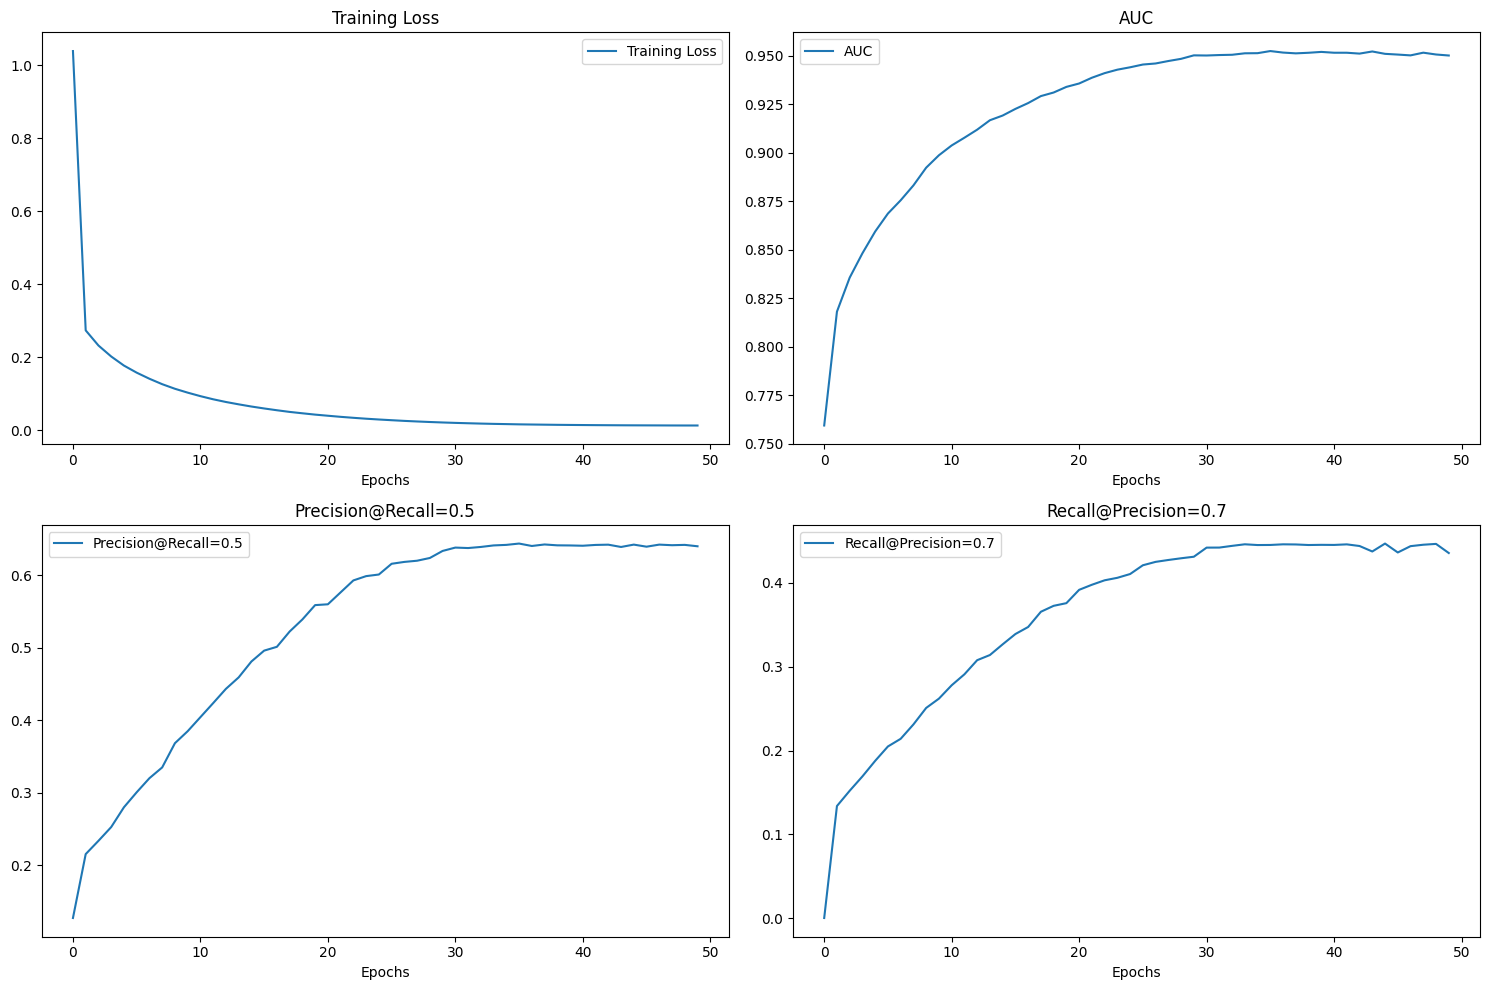

fit_history/model_1.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - auc: 0.9532 - loss: 0.0116 - precision_at_recall: 0.7108 - recall_at_precision: 0.5148
[0.011575944721698761, 0.714255154132843, 0.9620081186294556, 0.5224857926368713]


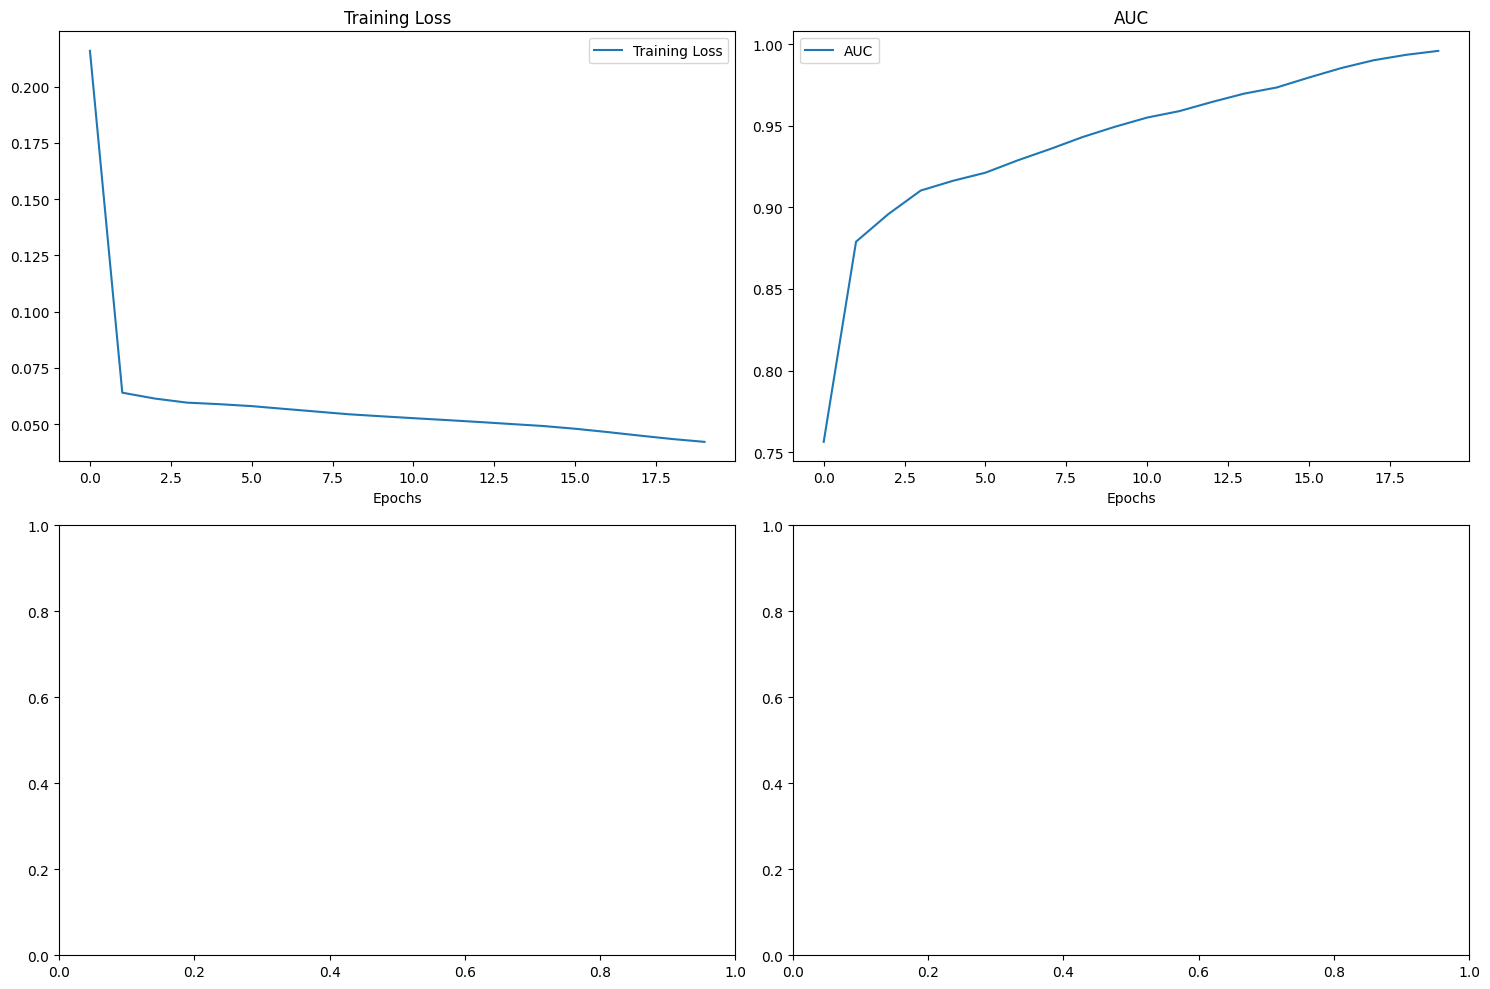

fit_history/model_2.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - auc: 0.8557 - f1_score: 0.1290 - loss: 0.0627 - precision_at_recall_1: 0.7951
[0.06262781471014023, 0.7901332378387451, 0.8635212779045105, 0.13166695833206177]


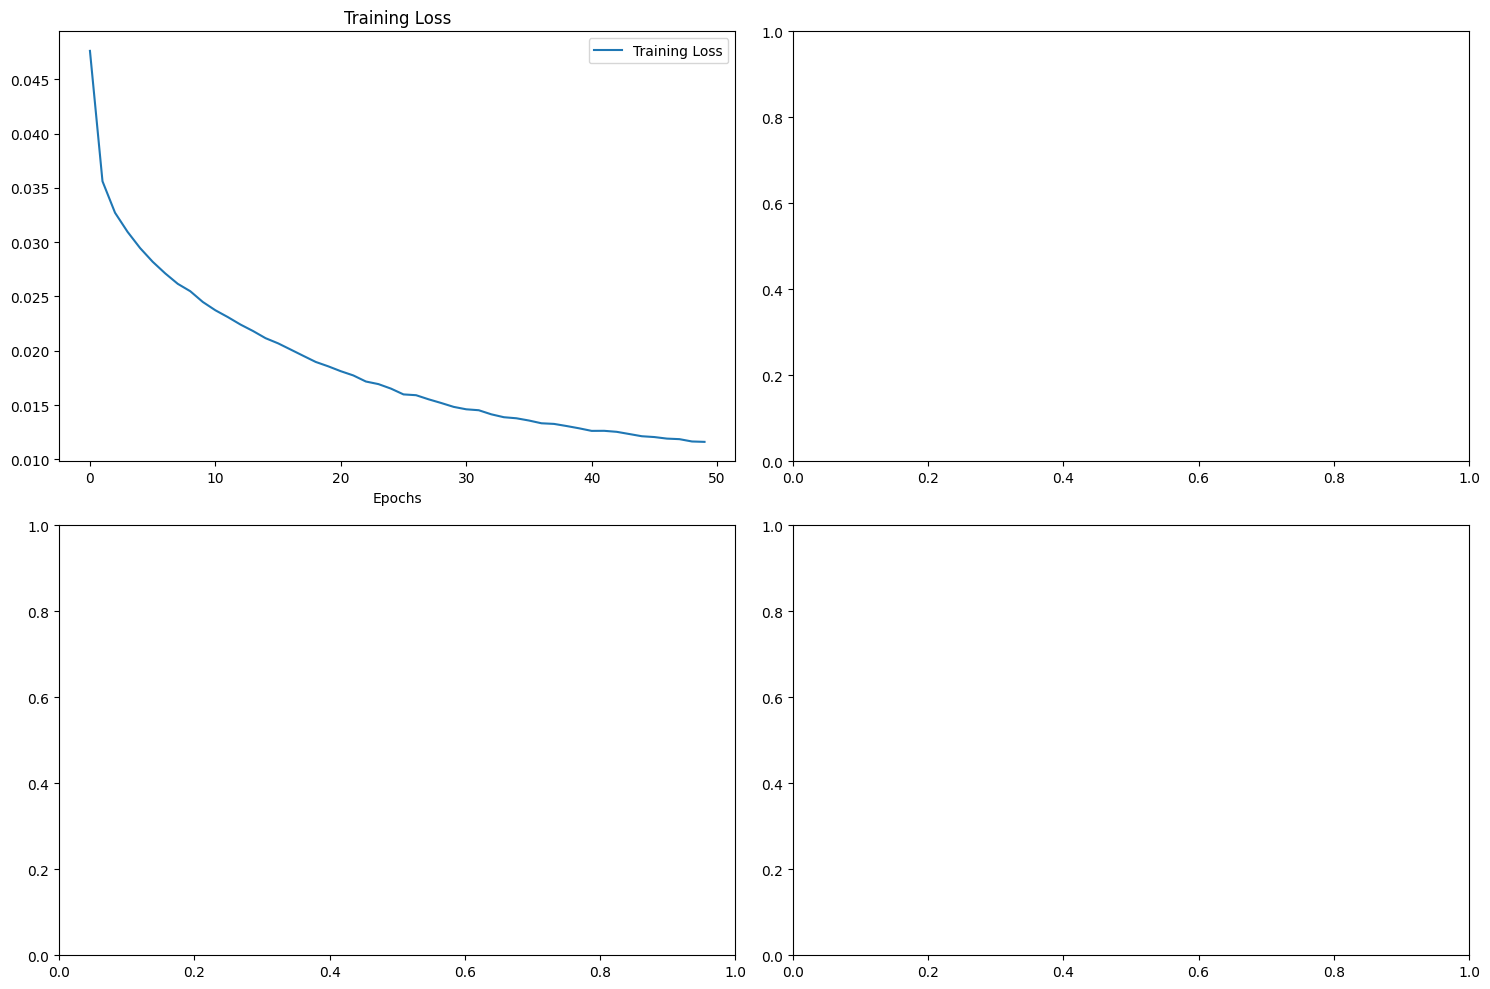

fit_history/model_3.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - auc_1: 0.8889 - f1_score: 0.6610 - loss: 0.0438 - precision_at_recall_2: 0.8267
[0.04350299760699272, 0.821823000907898, 0.8972722887992859, 0.6605985164642334]


In [50]:
prefix = "fit_history/"


for i in range(3):
    history = np.load(f"fit_history/hist_{i+1}.npy", allow_pickle=True).item()
    model = keras.models.load_model(f"fit_history/model_{i+1}.keras")
    plot_training_history(history.history)
    print(f"fit_history/model_{i+1}.keras")
    check_model(model)

### Тесты

In [148]:
import pandas as pd 
from ast import literal_eval

from nltk import FreqDist


data = pd.read_csv("processed_dataset/processed_questions.csv", encoding="ISO-8859-1", converters={
        "Tags": lambda x: literal_eval(x)
    })

flat_series = data['Tags'].explode()


keywords = FreqDist(flat_series)

In [155]:
for i in range(20):
    for tag, count in keywords.most_common(COMMON_TAGS_COUNT)[i*5:(i+1)*5]:
        print(f"{tag}: {count}", end="\t\t")
    print()

c#: 6907		java: 6862		javascript: 5560		android: 5052		python: 4442		
c++: 4369		php: 3024		jquery: 2770		.net: 2705		ios: 2685		
html: 2129		css: 1980		c: 1845		iphone: 1781		objective-c: 1768		
ruby-on-rails: 1524		sql: 1389		asp.net: 1302		mysql: 1286		ruby: 1249		
r: 1120		git: 1013		asp.net-mvc: 1004		linux: 935		sql-server: 907		
node.js: 875		angularjs: 873		django: 850		performance: 845		algorithm: 842		
string: 813		xcode: 804		arrays: 791		wpf: 791		eclipse: 786		
haskell: 728		windows: 721		scala: 709		multithreading: 702		json: 688		
c++11: 669		regex: 662		visual-studio: 592		html5: 585		osx: 582		
swift: 578		database: 571		unit-testing: 563		spring: 552		xml: 535		
bash: 523		ajax: 476		delphi: 438		cocoa-touch: 420		ruby-on-rails-3: 417		
visual-studio-2010: 410		linq: 409		debugging: 391		generics: 387		perl: 384		
entity-framework: 381		mongodb: 374		winforms: 363		cocoa: 359		security: 354		
postgresql: 350		css3: 346		templates: 345		twitter-bootstrap: 336		shell: 3

In [35]:
from tensorflow import keras
import joblib
from scipy.sparse import hstack


# Загрузка векторизаторов и бинаризатора
vectorizer_X1 = joblib.load("vectorizers/BodyVectorizer.pickle")
vectorizer_X2 = joblib.load("vectorizers/TitleVectorizer.pickle")
multilabel_binarizer = joblib.load("vectorizers/TagsVectorizer.pickle")

In [53]:
TITLE = """Make some buttons on frontend"""
BODY = """    
Create a button, which will use jQuery javascript script
"""

TITLE = """Fix user profile page"""
BODY = """    
Rewrite our python untyped backend view, which calculate user bonus amount, maybe fix celery, maybe it broke crontab 
"""

TITLE = """Refactor Backend Integration for Data Export"""
BODY = """
The current CSV export in PyQt5 blocks the UI thread.  
- Move export logic to a QThread worker.  
- Replace string concatenation with pandas DataFrame for CSV generation.  
- Add error handling for invalid data (show QMessageBox on failure).  
- Allow cancellation via a "Stop Export" button.  """

# TITLE = """Optimize Slow Customer Orders Query"""
# BODY = """
# The query fetching customer orders (JOIN on `customers`, `orders`, `products`) takes 15+ seconds.  
# - Analyze the execution plan with `EXPLAIN ANALYZE`.  
# - Add missing indexes (suggest candidates: `orders.customer_id`, `products.sku`).  
# - Rewrite the query to avoid correlated subqueries.  
# - Partition the `orders` table by `order_date` (YYYY-MM).  
# - Validate speed improvement (target: <1s).  
# """

# TITLE = """Dynamically added jQuery elements not triggering click events"""
# BODY = """I'm using jQuery to add new buttons to a div with append(), but the click events don't work on the new elements. My code:
# javascript
# Copy

# $('#container').append('<button class='btn'>Click me</button>');  
# $('.btn').on('click', () => alert('Button clicked'));  

# # Events work on initial buttons but not dynamically added ones. How can I fix this?"""

# TITLE = """RecyclerView not updating after adding new items in Android"""
# BODY = """
# I have a RecyclerView adapter that updates a list of data. After calling adapter.add(newItem) and adapter.notifyDataSetChanged(), the UI doesn't refresh. 
# My code uses ListAdapter with DiffUtil. What am I missing? Is there a threading issue?
# """

# TITLE = """Fix Cross-Platform Layout Issues in Flutter App"""  
# BODY = """  
# UI renders differently on iOS/Android devices (text overflow, alignment).  
# - Replace hardcoded sizes with MediaQuery-based layout.  
# - Implement platform-aware ThemeData (Cupertino/Material).  
# - Add golden tests for critical screens.  
# - Use Flex widgets instead of Row/Column nesting.  
# - Verify font scaling (1.0-2.0) accessibility requirements.  
# """


# TITLE = """Secure API Endpoints Against SQL Injection"""  
# BODY = """  
# Raw SQL queries in ASP.NET Core 6 controllers are vulnerable to injection.  
# - Replace string concatenation with Entity Framework parameterization.  
# - Add Dapper's `DynamicParameters` for complex queries.  
# - Implement regex filter for suspicious characters in request params.  
# - Create automated tests with SQLMAP test cases.  
# - Add rate limiting (max 5 req/sec) to brute-force endpoints.  
# """

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted tags: [('c#', 'sql-server')]


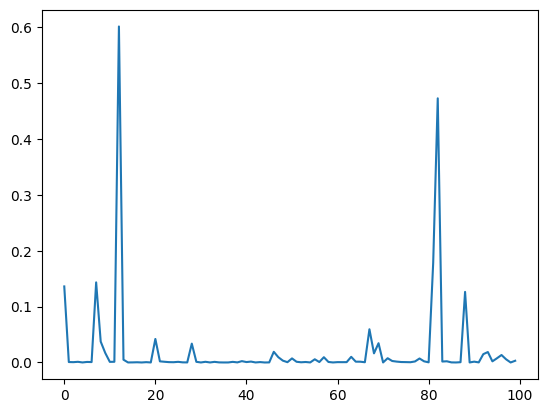

In [54]:
X1_new = vectorizer_X1.transform([TITLE])
X2_new = vectorizer_X2.transform([BODY])

# Объединение и преобразование в плотный формат
X_input = hstack([X1_new, X2_new]).toarray()  # (1, 2000)
# Загрузка модели
model = keras.models.load_model("fit_history/model_3.keras")

probas = model.predict(X_input)
labels = multilabel_binarizer.inverse_transform((probas > 0.20).astype(int))


print("Predicted tags:", labels)

# print(probas[0])

import matplotlib.pyplot as plt

plt.plot(probas[0])
